# Packages

In [2]:
import numpy as np
import math as m
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import scipy.stats as si
from scipy import stats
from scipy import special
from scipy.stats import norm
from matplotlib.pyplot import figure, show
from mpl_toolkits import  mplot3d
import time
%matplotlib notebook

## Parameters for options

In [3]:
dx=5;  # Stock price will increase by 2, spatial step.
dt=1/252; # 5 trading days 
K = 100; #Strike price
σ = 0.25#volatility under normal circumstances,
σJ= 0.18; # Volatility under jump 
r = 0.12 #risk-free interest rate
T = 12/12; #time to maturity
µ = 0.06; #mean
Smax =200 #maximum stock price
κ = np.exp(μ+0.5*σJ**2)-1 #Standard Impulse function.
Smin = 0; #minimum stock price
N=int((Smax-Smin)/dx)-1
M=int(T/dt)-1
λ=0.1 #arrival rate of the poisson process

## Initial and boundary conditions for put option

In [4]:
s = np.zeros((N,1));
for i in range(0, N):
    s[i] = Smin + i*dx;

t = np.zeros((M,1));
for n in range(0, M):
    t[n] = n*dt;


tau = np.zeros((M,1));
for n in range(0, M):
    tau[n] = T - t[n];

x = np.zeros((N,1))

for i in range(0, N):
    x[i] = np.log(s[i]);


[X_vals,T_vals] = np.meshgrid(tau,x);
[S_vals,t_vals] = np.meshgrid(t,s);

u = np.zeros((N,M));
for i in range(0,N):
    u[i,0] = max(K-s[i] ,0)  # Terminal condition

for n in range(0,M):
    u[0,n] = K*np.exp(-r*tau[n]);
    u[N-1,n] = 0;

## Jump Components for put option


In [5]:
Y= np.zeros(N) 
for i in range(0,N):
    
    a = (np.log(s[0])-np.log(s[i])- µ)/(σJ )
    Y[i]= (K*np.exp(-r*tau[n]))*(si.norm.cdf(a))

In [6]:
J = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N-1):
        J[i,j] = special.erf((np.log(s[j+1])-np.log(s[i])-µ)/(σJ* np.sqrt(2)))-special.erf((np.log(s[j-1])-np.log(s[i])-µ)/(σJ* np.sqrt(2)))




## Constants

In [7]:
rho = 0.5*σ**2
mu = r - λ*κ - 0.5*σ**2


## Explicit scheme

In [8]:
start_time = time.time()
Bound = (2*(r + λ)*dx + 4*λ)/(((r + λ)**2)*dx**2 + 4*λ*(r + λ)*dx + 4*λ**2)
print('The bound for dt is {} and the chosen value is {}'.format((np.round(Bound,4)),np.round(dt,4)))
print(' ')

for n in range(0,M-1):
    for i in range(0, N-1):
        u[i,n+1] = (rho*dt/dx**2 - mu*dt/2*dx)*u[i-1,n] + (-2*rho*dt/dx**2 - (r + λ)*dt + 1)*u[i,n]\
                 + (rho*dt/dx**2 +mu*dt/2*dx)*u[i+1,n] +λ*dt*(Y[i]+0.5*J[i,j]*((u[i,n]+u[i+1,n])/2))
end_time = time.time()
CPU_time = end_time - start_time
print('The total computation time is {} seconds '.format(np.round(CPU_time,)))

The bound for dt is 1.5385 and the chosen value is 0.004
 
The total computation time is 0.0 seconds 


## Black scholes exact solution

In [15]:
NC = norm.cdf

def BS_PUT(s, K, T, r, σ):
    d1 = (np.log(s/K) + (r + σ**2/2)*T) / (σ*np.sqrt(T))
    d2 = d1 - σ* np.sqrt(T)
    return K*np.exp(-r*T)*NC(-d2) - s*NC(-d1)    


## Merton Jump 

In [9]:

def merton_jump_put(s, K, T, r, σ, µ , κ, λ ):
    p = 0 # price of option
    for k in range(N):
        r_k = r - λ*(µ-1) + (k*np.log(µ ) ) / T
        σ_k = np.sqrt( σ**2 + (k* κ** 2) / T)
        k_fact = np.math.factorial(k) # 
        p += (np.exp(-µ*λ*T) * (µ*λ*T)**k / (k_fact)) \
                    * BS_PUT(s, K, T, r_k, σ_k)
    return p 


In [10]:
Vexact= merton_jump_put(s, K, T, r, σ, µ , κ, λ )

In [11]:
Vexact= merton_jump_put(s, K, T, r, σ, µ , κ, λ)
end_time = time.time()
CPU_time = end_time - start_time
print('The total computation time is {} seconds '.format(np.round(CPU_time/60,4)))

The total computation time is 0.0089 seconds 


In [12]:
vexact=BS_PUT(s, K, T, r, σ)

## Ploting the Graph

<IPython.core.display.Javascript object>


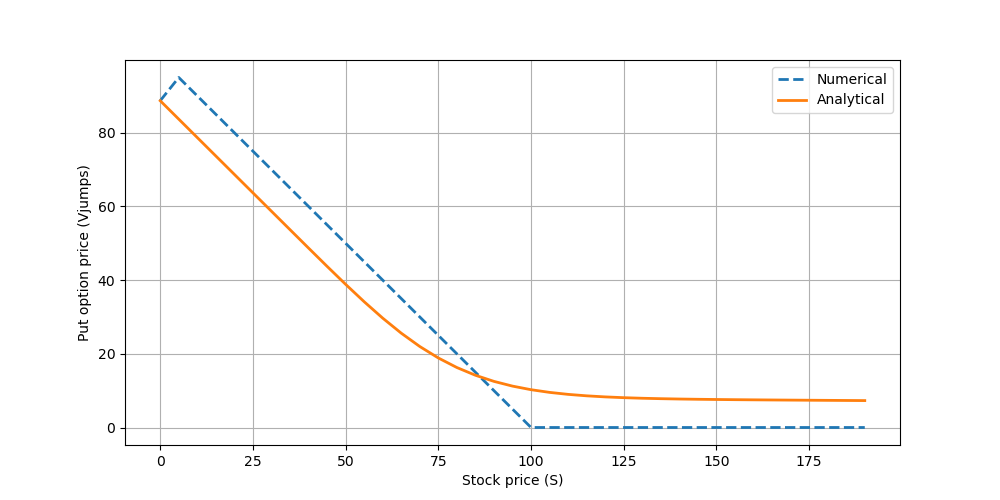

In [13]:
figure = plt.figure(figsize=(10,5))
plt.plot(s,u[:,0],'--',s,Vexact[:,0], lw=2)
plt.xlabel('Stock price (S)')
plt.ylabel('Put option price (Vjumps)')
plt.grid()
plt.legend(['Numerical','Analytical'])
plt.show()

## The relative error 

<IPython.core.display.Javascript object>


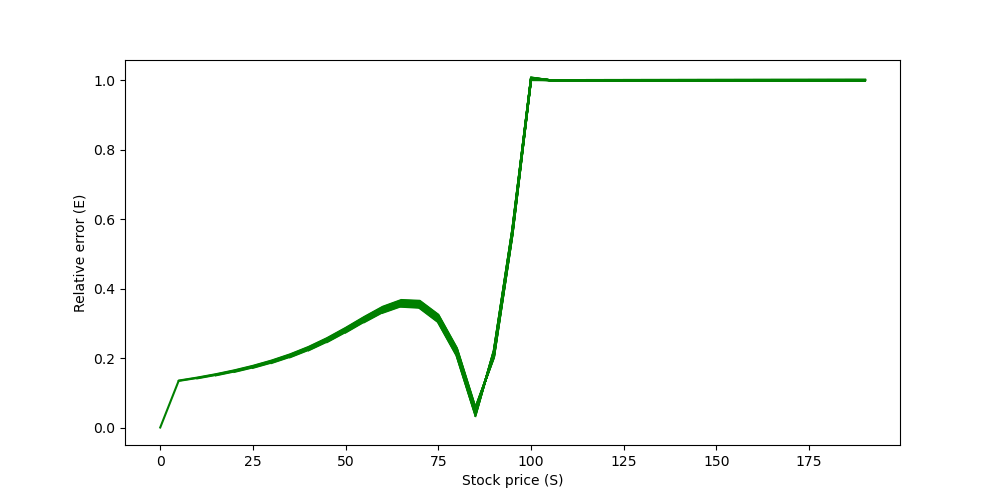

In [16]:
err = np.abs(Vexact - u)/np.abs(Vexact)
plt.figure(figsize=(10,5))
plt.plot(s,err,'g')
plt.xlabel('Stock price (S)')
plt.ylabel('Relative error (E)')
plt.show()